In [1]:
!pip install scikit-learn
!pip install mord

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd

data_meteo = pd.read_csv('../data/raw/meteo_sortie.csv')
data_meteo = data_meteo.drop(columns=data_meteo.columns[data_meteo.columns.str.startswith('Unnamed:')])
data_meteo = data_meteo.drop_duplicates(subset=['date', 'document_id'], keep='first')

In [3]:
# Compter le nombre de lignes par document_id
nombre_lignes_par_document_id = data_meteo['document_id'].value_counts()

# Trier les résultats dans l'ordre
nombre_lignes_par_document_id = nombre_lignes_par_document_id.sort_values(ascending=False)

# Afficher le résultat
print(nombre_lignes_par_document_id)


590801     31
603182     31
942329     31
1603976    31
1184994    31
           ..
611669     31
1512108    31
728781     31
1006279    31
706247     13
Name: document_id, Length: 20502, dtype: int64


In [4]:
data_meteo.sort_values(by=['document_id', 'date'], inplace=True)
grouped = data_meteo.groupby('document_id')

# Ajouter une nouvelle colonne "jour" avec le compteur pour chaque groupe
data_meteo['jour'] = grouped.cumcount() + 1

# Renommer les dates par jour1, jour2, etc. pour chaque document_id
data_meteo['jour'] = data_meteo['jour']
data_meteo.drop(columns=['date'], inplace=True)

In [5]:
index_to_drop = data_meteo.loc[data_meteo['jour'] > 31].index

# Supprimer les lignes correspondantes
data_meteo.drop(index=index_to_drop, inplace=True)
data_meteo['jour'] = 'jour' + data_meteo['jour'].astype(str)


In [6]:
data_meteo

temperature_2m_max  temperature_2m_min  daylight_duration  rain_sum  \
253872           -1.742500             -7.5925       38479.691406       0.0   
253873            0.207500             -5.8925       38645.136719       0.0   
253874            1.057500             -3.4925       38811.777344       0.0   
253875            0.607500             -3.1925       38979.468750       0.0   
253876           -1.492500             -6.2425       39148.058594       0.4   
...                    ...                 ...                ...       ...   
497620            8.736500             -0.3635       53620.636719       1.0   
497621           10.186500             -1.0635       53763.152344       5.9   
497622            7.636499             -1.0135       53903.804688       2.1   
497623            3.836500             -2.6135       54042.437500       3.9   
497624            4.186500             -6.0135       54178.917969       0.0   

        snowfall_sum  document_id    jour  
253872          1.75        58734   jour1  
253873          0.00        58734   jour2  
253874          0.21        58734   jour3  
253875          0.70        58734   jour4  
253876          3.08        58734   jour5  
...              ...          ...     ...  
497620          0.00      1647111  jour27  
497621          0.00      1647111  jour28  
497622          0.84      1647111  jour29  
497623          3.22      1647111  jour30  
497624          0.00      1647111  jour31  

[635544 rows x 7 columns]

In [7]:
pivot_data = data_meteo.pivot_table(index='document_id', columns='jour', aggfunc='first')
pivot_data.columns =[s1 + '_' + str(s2) for (s1,s2) in pivot_data.columns.tolist()]
# Réinitialiser l'index
pivot_data.reset_index(inplace=True)

In [8]:
import os
intermediate_meteo = pivot_data.copy()
if not os.path.isdir(os.path.join("./../data", "intermediate")):
    os.mkdir(os.path.join("./../data", "intermediate"))
intermediate_meteo.to_csv('../data/intermediate/pivotted_meteo.csv')

In [9]:
# building inter outings :

outings = pd.read_csv('../data/raw/outings.csv')
intermediate_outings = outings.loc[:, ['document_id', 'date_start', 'elevation_max', 'snow_quality', 'condition_rating', 'activity_snow_ice_mixed', 'activity_skitouring']]

/tmp/ipykernel_13074/3770927995.py:3: DtypeWarning: Columns (40,60) have mixed types. Specify dtype option on import or set low_memory=False.
  outings = pd.read_csv('../data/raw/outings.csv')


In [10]:
intermediate_outings

intermediate_outings.to_csv('../data/intermediate/filtered_columns_outings.csv')

In [11]:
intermediate_outings

document_id  date_start  elevation_max snow_quality condition_rating  \
0           590801  2015-01-06         2199.0          NaN             good   
1          1277964  2021-01-25         1494.0    excellent        excellent   
2          1122018  2019-06-19         4102.0         good             good   
3           499227  2014-03-02         1933.0          NaN          average   
4          1191547  2020-03-04            NaN          NaN             good   
...            ...         ...            ...          ...              ...   
32071      1413272  2022-04-14         4193.0      average             good   
32072       737009  2016-03-22         2364.0          NaN             good   
32073      1379207  2022-01-08         2280.0         good          average   
32074      1432031  2022-06-17         3842.0          NaN             poor   
32075       407186  2013-02-16         3404.0          NaN        excellent   

      activity_snow_ice_mixed activity_skitouring  
0                         NaN                True  
1                         NaN                True  
2                        True                 NaN  
3                         NaN                True  
4                        True                 NaN  
...                       ...                 ...  
32071                     NaN                True  
32072                     NaN                True  
32073                     NaN                True  
32074                    True                 NaN  
32075                     NaN                True  

[32076 rows x 7 columns]

In [12]:
# building datamart :
final_outings = intermediate_outings.copy()
# Créer une fonction pour mapper les valeurs
def map_activity(row):
    if row['activity_snow_ice_mixed'] == True and row['activity_skitouring'] == True :
        return 'both'
    if row['activity_snow_ice_mixed'] == True:
        return 'alpinism'
    elif row['activity_skitouring'] == True:
        return 'ski'
    else:
        return None  # ou une autre valeur par défaut si nécessaire

# Appliquer la fonction pour créer une nouvelle colonne "activity"
final_outings['activity'] = final_outings.apply(lambda row: map_activity(row), axis=1)
final_outings['date_start'] = pd.to_datetime(final_outings['date_start'])
final_outings['mois'] = 'm' + final_outings['date_start'].dt.month.astype(str)

final_outings.drop(columns=['activity_skitouring', 'activity_snow_ice_mixed', 'date_start'], inplace=True)
# Afficher le DataFrame résultant
print(final_outings)


       document_id  elevation_max snow_quality condition_rating  activity mois
0           590801         2199.0          NaN             good       ski   m1
1          1277964         1494.0    excellent        excellent       ski   m1
2          1122018         4102.0         good             good  alpinism   m6
3           499227         1933.0          NaN          average       ski   m3
4          1191547            NaN          NaN             good  alpinism   m3
...            ...            ...          ...              ...       ...  ...
32071      1413272         4193.0      average             good       ski   m4
32072       737009         2364.0          NaN             good       ski   m3
32073      1379207         2280.0         good          average       ski   m1
32074      1432031         3842.0          NaN             poor  alpinism   m6
32075       407186         3404.0          NaN        excellent       ski   m2

[32076 rows x 6 columns]


In [13]:
final_outings

document_id  elevation_max snow_quality condition_rating  activity mois
0           590801         2199.0          NaN             good       ski   m1
1          1277964         1494.0    excellent        excellent       ski   m1
2          1122018         4102.0         good             good  alpinism   m6
3           499227         1933.0          NaN          average       ski   m3
4          1191547            NaN          NaN             good  alpinism   m3
...            ...            ...          ...              ...       ...  ...
32071      1413272         4193.0      average             good       ski   m4
32072       737009         2364.0          NaN             good       ski   m3
32073      1379207         2280.0         good          average       ski   m1
32074      1432031         3842.0          NaN             poor  alpinism   m6
32075       407186         3404.0          NaN        excellent       ski   m2

[32076 rows x 6 columns]

In [14]:
final_meteo = intermediate_meteo.copy()
# Créer une fonction pour calculer la moyenne sur une plage de colonnes
def calculer_moyenne(row, debut, fin, name_col):
    colonnes = [f'{name_col}{i}' for i in range(debut, fin+1)]
    return row[colonnes].mean()

def make_window_mean_data(df, name_col):
    dfcopy = df.copy()
    # Calculer les moyennes pour les plages spécifiées
    dfcopy['moyenne_' + name_col + '_jour_1_20'] = dfcopy.apply(lambda row: calculer_moyenne(row, 1, 20, name_col), axis=1)
    dfcopy['moyenne_' + name_col + '_jour_20_25'] = dfcopy.apply(lambda row: calculer_moyenne(row, 20, 25, name_col), axis=1)
    dfcopy['moyenne_' + name_col + '_jour_26_29'] = dfcopy.apply(lambda row: calculer_moyenne(row, 26, 29, name_col), axis=1)
    # Liste des colonnes originales
    colonnes_originales = [f'{name_col}{i}' for i in range(1, 30)]
    
    
    # Supprimer les colonnes originales
    dfcopy.drop(columns=colonnes_originales, inplace=True)
    return dfcopy

final_meteo = make_window_mean_data(final_meteo, 'daylight_duration_jour')
final_meteo = make_window_mean_data(final_meteo, 'rain_sum_jour')
final_meteo = make_window_mean_data(final_meteo, 'temperature_2m_min_jour')
final_meteo = make_window_mean_data(final_meteo, 'temperature_2m_max_jour')
final_meteo = make_window_mean_data(final_meteo, 'snowfall_sum_jour')




In [15]:
final_meteo

document_id  daylight_duration_jour30  daylight_duration_jour31  \
0            58734              43466.429688              43641.640625   
1            58950              34671.285156              34557.750000   
2            59496              42378.218750              42553.160156   
3            59923              53968.855469              54059.281250   
4            59956              54532.609375              54598.804688   
...            ...                       ...                       ...   
20497      1646766              52778.480469              52931.746094   
20498      1646786              53485.031250              53639.281250   
20499      1646837              53816.343750              53957.792969   
20500      1647057              52063.835938              52194.492188   
20501      1647111              54042.437500              54178.917969   

       rain_sum_jour30  rain_sum_jour31  snowfall_sum_jour30  \
0                  0.0         0.000000                 1.61   
1                  0.0         0.000000                 1.26   
2                  0.0         3.300000                 0.00   
3                  6.4         0.500000                 0.00   
4                  3.1         3.600000                 0.00   
...                ...              ...                  ...   
20497              0.0         0.000000                 1.82   
20498              0.0         0.000000                 0.00   
20499              4.7         9.999999                 0.00   
20500              0.0         1.900000                 0.00   
20501              3.9         0.000000                 3.22   

       snowfall_sum_jour31  temperature_2m_max_jour30  \
0                     0.00                     0.0075   
1                     0.00                    -9.3020   
2                     2.52                    10.1330   
3                     0.00                     6.3040   
4                     0.00                    10.4085   
...                    ...                        ...   
20497                 0.00                     3.2285   
20498                 0.00                     1.0600   
20499                 0.21                    13.5905   
20500                 0.00                    12.8365   
20501                 0.00                     3.8365   

       temperature_2m_max_jour31  temperature_2m_min_jour30  ...  \
0                       2.007500                    -5.3425  ...   
1                      -8.902000                   -14.2520  ...   
2                       5.283000                    -0.7670  ...   
3                       5.454000                    -3.3960  ...   
4                       9.458499                     0.1585  ...   
...                          ...                        ...  ...   
20497                   4.728500                    -5.2215  ...   
20498                   1.410000                    -7.4900  ...   
20499                   9.490500                     1.1405  ...   
20500                  14.236500                    -3.0635  ...   
20501                   4.186500                    -2.6135  ...   

       moyenne_rain_sum_jour_jour_26_29  \
0                              0.975000   
1                              0.175000   
2                              0.000000   
3                              7.800001   
4                              3.250000   
...                                 ...   
20497                          1.225000   
20498                          0.600000   
20499                          1.500000   
20500                          0.575000   
20501                          2.375000   

       moyenne_temperature_2m_min_jour_jour_1_20  \
0                                        -6.8450   
1                                        -1.3920   
2                                        -4.2420   
3                                        -3.8185   
4                                        -3.9240   
...               

In [41]:
datamart = final_meteo.merge(final_outings, how='inner', on='document_id')

In [42]:
print("Contenu initial de la colonne 'snow_quality':")
print(datamart['snow_quality'].unique())

print("\nContenu initial de la colonne 'condition_rating':")
print(datamart['condition_rating'].unique())


Contenu initial de la colonne 'snow_quality':
[nan 'good' 'excellent' 'average' 'poor' 'awful']

Contenu initial de la colonne 'condition_rating':
[nan 'poor' 'average' 'excellent' 'good' 'awful']


In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from mord import LogisticIT
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE

scaler = MinMaxScaler()
datamart = final_meteo.merge(final_outings, how='inner', on='document_id')
datamart = datamart[datamart['activity'] == 'ski']
# Supprimer les colonnes d'index et de document_id
datamart = datamart.drop(columns=['document_id'])
datamart_filtered = datamart.dropna(subset=['snow_quality', 'condition_rating'])

snow_quality_order = ['awful', 'poor', 'average', 'good', 'excellent']
condition_rating_order = ['awful', 'poor', 'average', 'good', 'excellent']

# Créer l'encodeur en spécifiant l'ordre
ordinal_encoder = OrdinalEncoder(categories=[snow_quality_order, condition_rating_order], handle_unknown='use_encoded_value', unknown_value=-1)

# Appliquer l'encodage aux données
datamart_filtered[['snow_quality', 'condition_rating']] = ordinal_encoder.fit_transform(datamart_filtered[['snow_quality', 'condition_rating']])
# Diviser les données en ensembles d'entraînement et de test
X = datamart_filtered.drop(columns=['snow_quality', 'condition_rating'])
qualitative_data = X.select_dtypes(include=['object'])

# Appliquer un encodage adapté aux données qualitatives
# Par exemple, encodage one-hot
encoded_qualitative_data = pd.get_dummies(qualitative_data)

# Sélectionner les colonnes contenant des données quantitatives dans X
quantitative_data = X.select_dtypes(exclude=['object'])

# Concaténer les données qualitatives encodées et quantitatives
X_processed = pd.concat([encoded_qualitative_data, quantitative_data], axis=1)
X_processed.fillna(X_processed.median(), inplace=True)
X_processed_normalized = scaler.fit_transform(X_processed)
n_components = min(X_processed_normalized.shape[0], X_processed_normalized.shape[1])
pca = PCA(n_components=n_components)

# Appliquer PCA sur X_processed_normalized
X_pca = pca.fit_transform(X_processed_normalized)

# Sélectionner les 10 premières composantes principales
X_PCA = X_pca[:, :10]

y_snow_quality = datamart_filtered['snow_quality'].astype(int)
y_condition_rating = datamart_filtered['condition_rating'].astype(int)


resample=True
if resample:
    sm_snow = SMOTE(random_state=42)
    X_processed_normalized_snow, y_snow_quality = sm_snow.fit_resample(X_processed_normalized, y_snow_quality)
    sm_cond = SMOTE(random_state=42)
    X_processed_normalized_cond, y_condition_rating = sm_cond.fit_resample(X_processed_normalized, y_condition_rating)
else:
    X_processed_normalized_snow, y_snow_quality = X_processed_normalized, y_snow_quality
    X_processed_normalized_cond, y_condition_rating = X_processed_normalized, y_condition_rating


/tmp/ipykernel_13074/2588826913.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datamart_filtered[['snow_quality', 'condition_rating']] = ordinal_encoder.fit_transform(datamart_filtered[['snow_quality', 'condition_rating']])


In [55]:
X_train_snow, X_test_snow, y_snow_quality_train, y_snow_quality_test =  train_test_split(X_processed_normalized_snow, y_snow_quality, test_size=0.2, random_state=42)
X_train_cond, X_test_cond, y_condition_rating_train, y_condition_rating_test = train_test_split(X_processed_normalized_cond, y_condition_rating, test_size=0.2, random_state=42)

# Entraîner le modèle de régression logistique ordinale pour snow_quality
model_snow_quality = MLPClassifier(random_state=1)
model_snow_quality.fit(X_train_snow, y_snow_quality_train)

# Entraîner le modèle de régression logistique ordinale pour condition_rating
model_condition_rating = MLPClassifier(random_state=1)
model_condition_rating.fit(X_train_cond, y_condition_rating_train)

# Évaluer les performances du modèle pour snow_quality sur l'ensemble d'entraînement
accuracy_snow_quality_train = model_snow_quality.score(X_train_snow, y_snow_quality_train)
print("Précision du modèle pour snow_quality (entraînement) :", accuracy_snow_quality_train)
accuracy_snow_quality = model_snow_quality.score(X_test_snow, y_snow_quality_test)
print("Précision du modèle pour snow_quality :", accuracy_snow_quality)


# Évaluer les performances du modèle pour condition_rating sur l'ensemble d'entraînement
accuracy_condition_rating_train = model_condition_rating.score(X_train_cond, y_condition_rating_train)
print("Précision du modèle pour condition_rating (entraînement) :", accuracy_condition_rating_train)
# Évaluer les performances du modèle pour condition_rating
accuracy_condition_rating = model_condition_rating.score(X_test_cond, y_condition_rating_test)
print("Précision du modèle pour condition_rating :", accuracy_condition_rating)




/home/david/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Précision du modèle pour snow_quality (entraînement) : 0.605945521215296
Précision du modèle pour snow_quality : 0.5589313776846516
Précision du modèle pour condition_rating (entraînement) : 0.6087635054021608
Précision du modèle pour condition_rating : 0.5872749099639856


/home/david/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


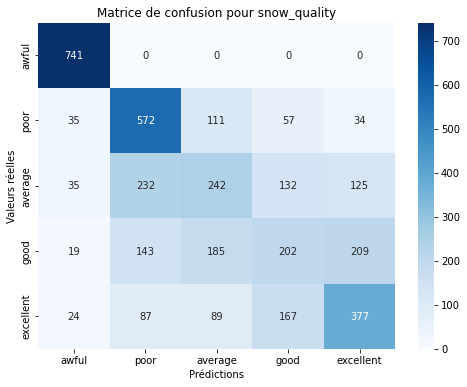

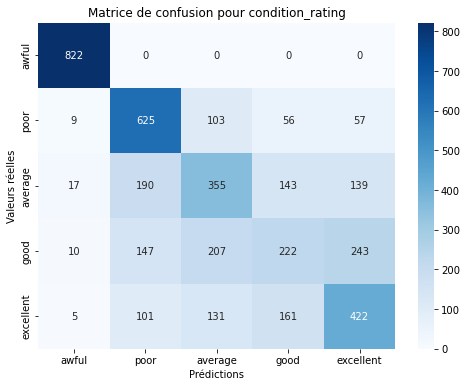

In [56]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
    
    # Matrice de confusion pour snow_quality
    conf_matrix_snow_quality = confusion_matrix(y_snow_quality_test, model_snow_quality.predict(X_test_snow))
    
    # Matrice de confusion pour condition_rating
    conf_matrix_condition_rating = confusion_matrix(y_condition_rating_test, model_condition_rating.predict(X_test_cond))
    
    # Plot de la matrice de confusion pour snow_quality
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_snow_quality, annot=True, fmt='d', cmap='Blues', xticklabels=snow_quality_order, yticklabels=snow_quality_order)
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title('Matrice de confusion pour snow_quality')
    plt.show()
    
    # Plot de la matrice de confusion pour condition_rating
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_condition_rating, annot=True, fmt='d', cmap='Blues', xticklabels=condition_rating_order, yticklabels=condition_rating_order)
    plt.xlabel('Prédictions')
    plt.ylabel('Valeurs réelles')
    plt.title('Matrice de confusion pour condition_rating')
    plt.show()

In [53]:
"""from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import numpy as np

# Définir les hyperparamètres à tester
param_grid = {
    'hidden_layer_sizes': [(5,5), (10,10), (20,), (100,)],
    'activation': [relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant','adaptive'],
}

# Initialiser le modèle
mlp = MLPClassifier(random_state=1)

# Initialiser GridSearchCV
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Effectuer la recherche par grille sur l'ensemble de données condition_rating
grid_search.fit(X_train_cond, y_condition_rating_train)

# Afficher les meilleurs hyperparamètres trouvés
print("Meilleurs hyperparamètres pour condition_rating:", grid_search.best_params_)

# Évaluer les performances du modèle avec les meilleurs hyperparamètres
best_model = grid_search.best_estimator_
accuracy_condition_rating = best_model.score(X_test_cond, y_condition_rating_test)
print("Précision du meilleur modèle pour condition_rating :", accuracy_condition_rating)"""


'from sklearn.model_selection import GridSearchCV\nfrom sklearn.neural_network import MLPClassifier\nimport numpy as np\n\n# Définir les hyperparamètres à tester\nparam_grid = {\n    \'hidden_layer_sizes\': [(5,5), (10,10), (20,), (100,)],\n    \'activation\': [relu\'],\n    \'solver\': [\'adam\'],\n    \'alpha\': [0.0001],\n    \'learning_rate\': [\'constant\',\'adaptive\'],\n}\n\n# Initialiser le modèle\nmlp = MLPClassifier(random_state=1)\n\n# Initialiser GridSearchCV\ngrid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)\n\n# Effectuer la recherche par grille sur l\'ensemble de données condition_rating\ngrid_search.fit(X_train_cond, y_condition_rating_train)\n\n# Afficher les meilleurs hyperparamètres trouvés\nprint("Meilleurs hyperparamètres pour condition_rating:", grid_search.best_params_)\n\n# Évaluer les performances du modèle avec les meilleurs hyperparamètres\nbest_model = grid_search.best_estimator_\naccuracy_condition_rating = best_mo